## Basics

In [1]:
from primitives import Parameters
p = Parameters()
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

(100,)


In [3]:
#%%timeit
from Multiworker_Contract import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
#(mwc_J,mwc_W,mwc_Wstar,mwc_pc)=mwc.J()
(mwc_J,mwc_W,mwc_Wstar,mwc_pc)=mwc.J()

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\primitives.py:172: RuntimeWarning: divide by zero encountered in power
  return np.divide(aa * np.power( wage, self.p.tax_lambda * (1.0 - self.p.u_rho)) - self.p.u_b,
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()


Ji shape (7, 4, 4, 100)
W1i shape (7, 4, 4, 100, 2)


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: invalid value encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()


Ji at zero size [0. 0. 0. 0. 0. 0. 0.]
EJpi at zero size 0.0


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:172: RuntimeWarning: invalid value encountered in scalar divide
  self.gamma_all[iz, in0, in1, 1] = ( (Xi-xbar) * (Yi-ybar) * W ).sum() / (  (Xi-xbar) * (Xi-ybar) * W ).sum()


Errors: nan 0.0028564674179646777 nan 13674.443417985793 1
Errors: nan 0.0028564674179646777 nan 13674.443417985793 1
Ji at zero size [0. 0. 0. 0. 0. 0. 0.]
EJpi at zero size 0.0
Ji at zero size [0. 0. 0. 0. 0. 0. 0.]
EJpi at zero size 0.0
EJinv -950.3957545664091
EJinv diff: 131.69356408355296
EJinv diff max: 245.28075713512942
Ji at zero size [0. 0. 0. 0. 0. 0. 0.]
EJpi at zero size 0.0
EJinv -934.4995323453763
EJinv diff: 819.8147973365109
EJinv diff max: 617.0730863236563
Ji at zero size [0. 0. 0. 0. 0. 0. 0.]
EJpi at zero size 0.0
EJinv -918.270248204218
EJinv diff: 89.1211302400296
EJinv diff max: 179.03282081573866
Ji at zero size [0. 0. 0. 0. 0. 0. 0.]
EJpi at zero size 0.0
EJinv -901.8633307019212
EJinv diff: 204.7580927489824
EJinv diff max: 244.98792290544765
Ji at zero size [0. 0. 0. 0. 0. 0. 0.]
EJpi at zero size 0.0
EJinv -885.4023660653056
EJinv diff: 212.3266093557234
EJinv diff max: 285.356073417546
Ji at zero size [0. 0. 0. 0. 0. 0. 0.]
EJpi at zero size 0.0
EJinv -86

KeyboardInterrupt: 

In [3]:
#%%timeit
from Multiworker_Contract_diff_inter import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
#(mwc_J,mwc_W,mwc_Wstar,mwc_pc)=mwc.J()
(mwc_inter_J,mwc_inter_W,mwc_inter_Wstar,mwc_inter_pc)=mwc.J()

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\primitives.py:172: RuntimeWarning: divide by zero encountered in power
  return np.divide(aa * np.power( wage, self.p.tax_lambda * (1.0 - self.p.u_rho)) - self.p.u_b,
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()


Ji shape (7, 4, 4, 100)
W1i shape (7, 4, 4, 100, 2)


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: invalid value encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:172: RuntimeWarning: invalid value encountered in scalar divide
  self.gamma_all[iz, in0, in1, 1] = ( (Xi-xbar) * (Yi-ybar) * W ).sum() / (  (Xi-xbar) * (Xi-ybar) * W ).sum()


Errors: nan 0.0073825295150724436 nan 15808.144002141904 1
Errors: nan 0.0073825295150724436 nan 15808.144002141904 1
EJinv -900.7072002848961
EJinv diff: 103.56110178539174
EJinv diff max: 218.99637486373638
EJinv -899.8289413061373
EJinv diff: 1308.2434667108591
EJinv diff max: 935.5194143565715
EJinv -895.6702165647498
EJinv diff: 121.40695342511562
EJinv diff max: 256.6846509017474
EJinv -888.9755729508746
EJinv diff: 230.81554674936675
EJinv diff max: 368.68908145317613
EJinv -880.3394890790466
EJinv diff: 287.81449692913054
EJinv diff max: 421.1074162979879
EJinv -870.236313413014
EJinv diff: 121.40054189045456
EJinv diff max: 226.17286426665427
EJinv -859.0442244003294
EJinv diff: 3193543.550276001
EJinv diff max: 47279.647370505445
EJinv -847.0644074773105
EJinv diff: 382.42451204782935
EJinv diff max: 458.5460659893728
EJinv -834.5364048828897
EJinv diff: 65.16250999094045
EJinv diff max: 139.89707304810372
Errors: nan 0.00046784445513936416 nan 7.333594552361506e-06 1
EJinv -

In [3]:
#%%timeit
from Multiworker_Contract_sep import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_s_pc)=mwc.J()

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\primitives.py:172: RuntimeWarning: divide by zero encountered in power
  return np.divide(aa * np.power( wage, self.p.tax_lambda * (1.0 - self.p.u_rho)) - self.p.u_b,
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()


Ji shape (7, 4, 4, 100)
W1i shape (7, 4, 4, 100, 2)


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: invalid value encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:172: RuntimeWarning: invalid value encountered in scalar divide
  self.gamma_all[iz, in0, in1, 1] = ( (Xi-xbar) * (Yi-ybar) * W ).sum() / (  (Xi-xbar) * (Xi-ybar) * W ).sum()


Errors: nan 0.0006395032611634684 nan 7777.946899554126 1
Errors: nan 0.0006395032611634684 nan 7777.946899554126 1


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:33: RuntimeWarning: invalid value encountered in power
  Xi_pow = np.power( Xi_arg , gamma[2])


EJinv diff: 0.8891052714552663
EJinv diff max: 25846.0399658849
sep borders 0.0 0.0
EJinv diff: 1.1343434338041847
EJinv diff max: 21590.017617229914
sep borders 0.0 1.0
EJinv diff: 2.5307099535048185
EJinv diff max: 19048.413891768094
sep borders 0.0 1.0
EJinv diff: 62.271801426571486
EJinv diff max: 18829.04292925719
sep borders 0.0 1.0
EJinv diff: 2.170063044707318
EJinv diff max: 21242.760518076968
sep borders 0.0 1.0
EJinv diff: 1.6292760645307696
EJinv diff max: 25235.663833667226
sep borders 0.0 1.0
EJinv diff: 1.9412174901512629
EJinv diff max: 33099.59373295964
sep borders 0.0 1.0
EJinv diff: 4.049488297649009
EJinv diff max: 55718.52203299537
sep borders 0.0 1.0
EJinv diff: 743.6421651364477
EJinv diff max: 754243.857848019
sep borders 0.0 1.0
Errors: nan 0.00018386100827876017 nan 7.741626230323158e-05 1
EJinv diff: 5.5391768465947
EJinv diff max: 44541.81439838492
sep borders 0.0 1.0
EJinv diff: 2.8265788252461137
EJinv diff max: 39315.29048845912
sep borders 0.0 1.0
EJinv 

In [ ]:
#%%timeit
from Multiworker_Contract_sep_direct import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_s_pc)=mwc.J()

# Plots

In [6]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

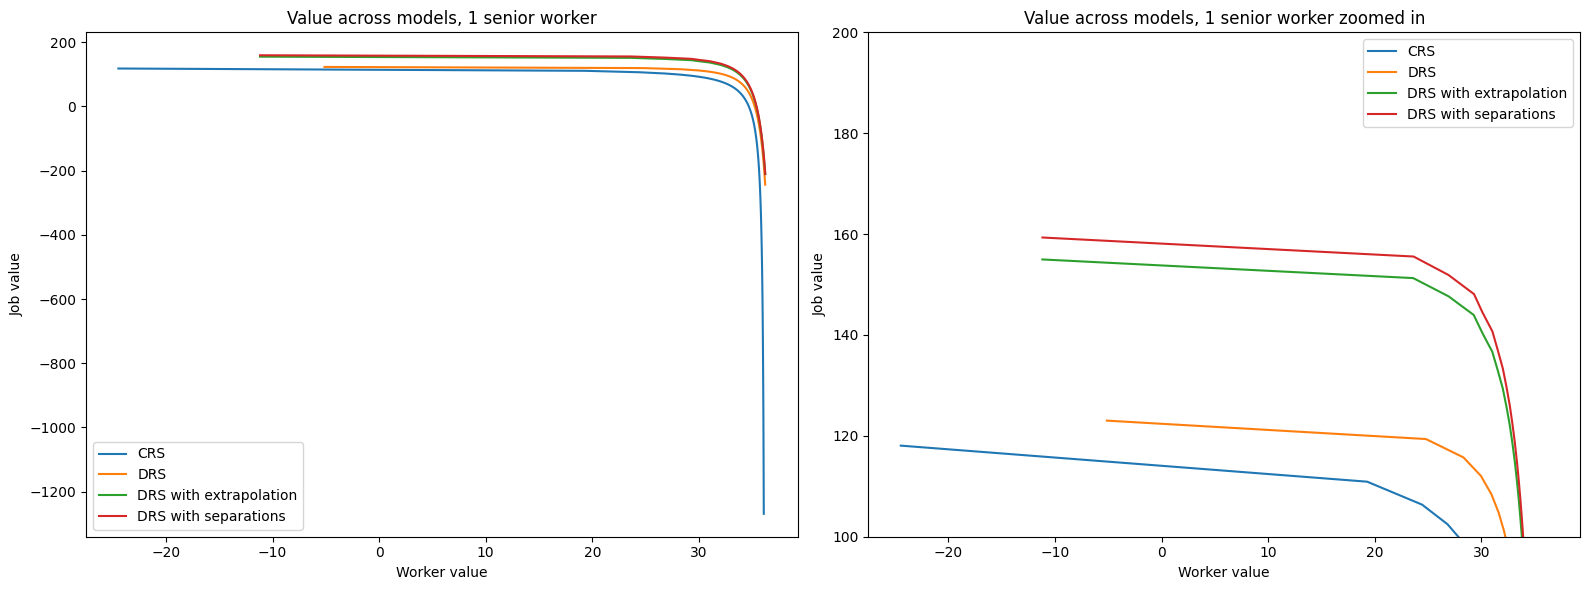

In [7]:
# Create a figure with a specific size
plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
# Plot the data
plt.plot(cc_W[p.z_0-1, :], cc_J[p.z_0-1, :], label='CRS')
plt.plot(mwc_W[p.z_0-1, 0, 1, :, 1], mwc_J[p.z_0-1, 0, 1, :], label='DRS')
plt.plot(mwc_inter_W[p.z_0-1, 0, 1, :, 1], mwc_inter_J[p.z_0-1, 0, 1, :], label='DRS with extrapolation')
plt.plot(mwc_s_W[p.z_0-1, 0, 1, :, 1], mwc_s_J[p.z_0-1, 0, 1, :], label='DRS with separations')
# Add titles and labels
plt.title('Value across models, 1 senior worker')
plt.xlabel('Worker value')
plt.ylabel('Job value')

plt.legend()

#plt.ylim([0, 200])

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(cc_W[p.z_0-1, :], cc_J[p.z_0-1, :], label='CRS')
plt.plot(mwc_W[p.z_0-1, 0, 1, :, 1], mwc_J[p.z_0-1, 0, 1, :], label='DRS')
plt.plot(mwc_inter_W[p.z_0-1, 0, 1, :, 1], mwc_inter_J[p.z_0-1, 0, 1, :], label='DRS with extrapolation')
plt.plot(mwc_s_W[p.z_0-1, 0, 1, :, 1], mwc_s_J[p.z_0-1, 0, 1, :], label='DRS with separations')

# Add titles and labels
plt.title('Value across models, 1 senior worker zoomed in')
plt.xlabel('Worker value')
plt.ylabel('Job value')

plt.ylim([100, 200])

plt.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Add legend
plt.legend()

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG


# Optionally set x and y limits
#plt.xlim([-10, 40])
#plt.ylim([0, 200])
# Save the plot to a file
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS zoom.png'), bbox_inches='tight')  # Save as PNG

# Show the plot (optional)
plt.show()

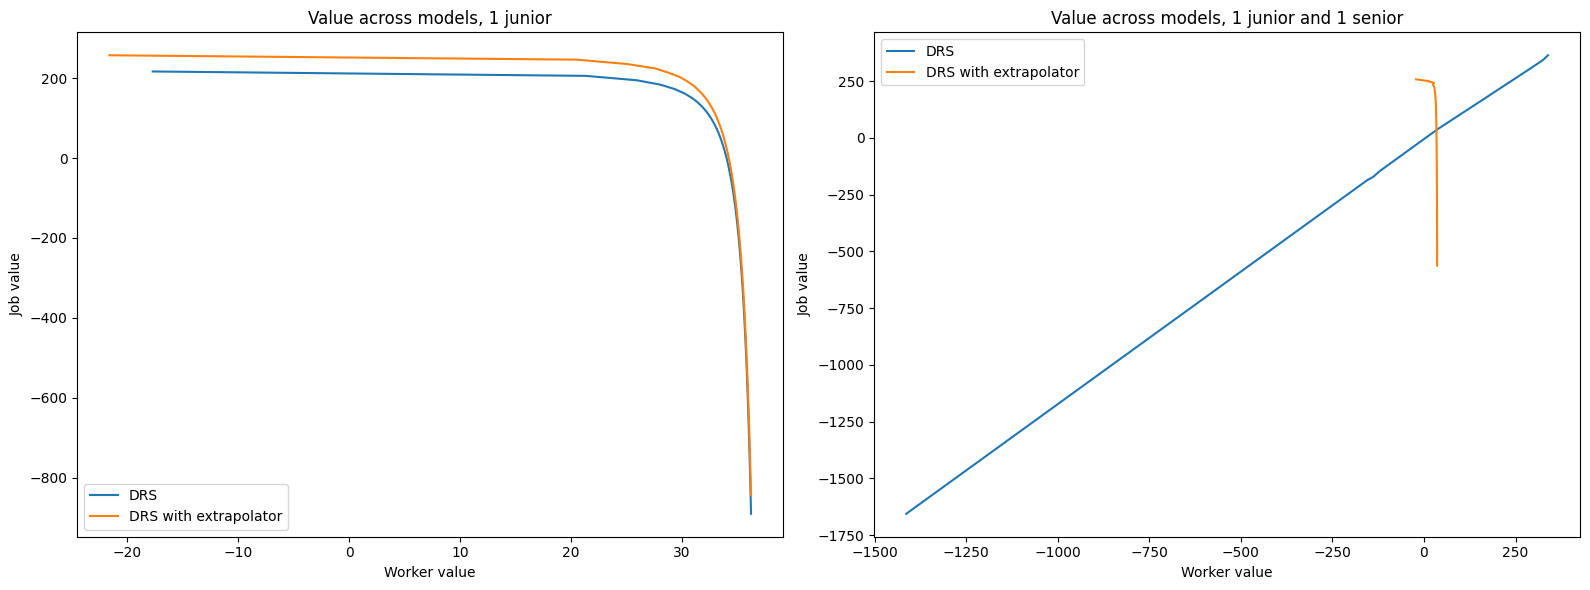

In [8]:
import matplotlib.pyplot as plt
import os

# Create a figure with a specific size
plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(mwc_W[p.z_0-1, 0, 3, :, 1], mwc_J[p.z_0-1, 0, 3, :], label='DRS')
plt.plot(mwc_inter_W[p.z_0-1, 0, 3, :, 1], mwc_inter_J[p.z_0-1, 0, 3, :], label='DRS with extrapolator')
plt.title('Value across models, 1 junior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

#plt.ylim([0, 200])

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(mwc_W[p.z_0-1, 2, 2, :, 1], mwc_J[p.z_0-1, 2, 2, :], label='DRS')
plt.plot(mwc_inter_W[p.z_0-1, 1, 2, :, 1], mwc_inter_J[p.z_0-1, 1, 2, :], label='DRS with extrapolator')
plt.title('Value across models, 1 junior and 1 senior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

#plt.xlim([-10, 10])
#plt.ylim([220, 240])

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG

# Show the plot
plt.show()

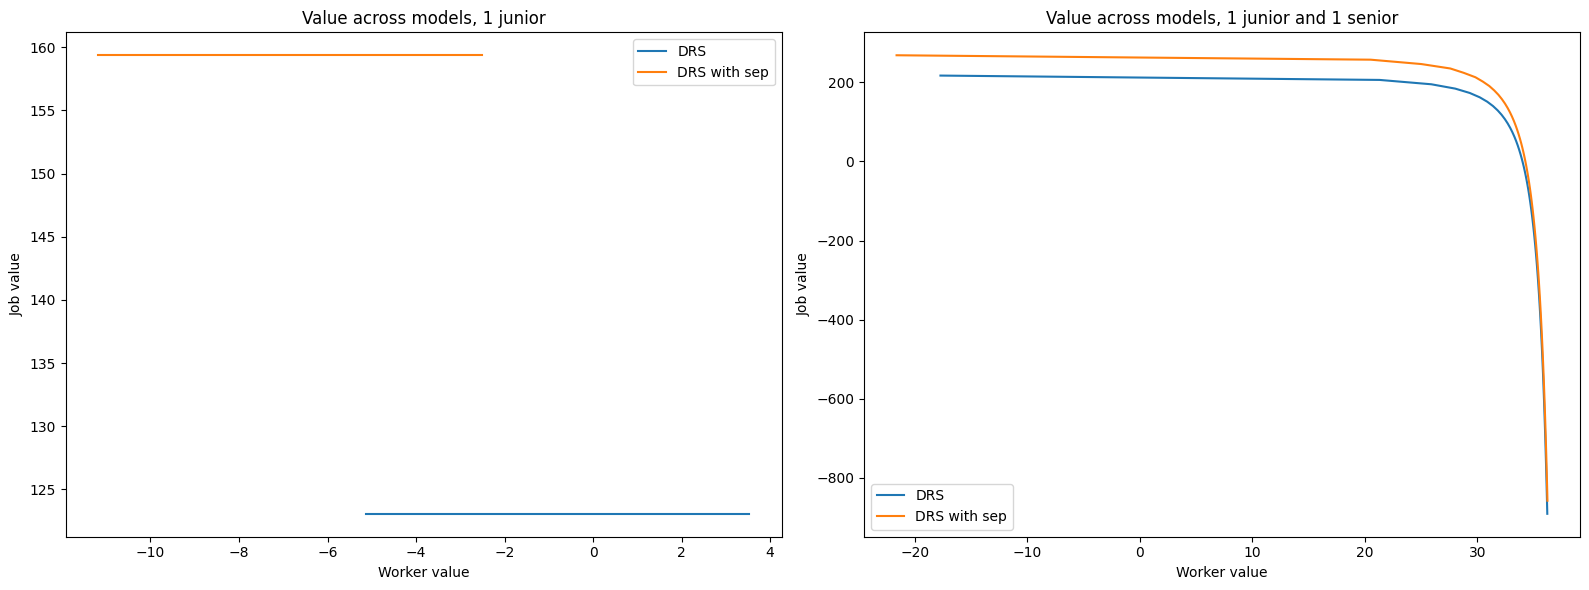

In [11]:
import matplotlib.pyplot as plt
import os

# Create a figure with a specific size
plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(mwc_W[p.z_0-1, 1, 0, :, 1], mwc_J[p.z_0-1, 1, 0, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, 1, 0, :, 1], mwc_s_J[p.z_0-1, 1, 0, :], label='DRS with sep')
plt.title('Value across models, 1 junior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

#plt.ylim([0, 200])

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(mwc_W[p.z_0-1, 0, 3, :, 1], mwc_J[p.z_0-1, 0, 3, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, 0, 3, :, 1], mwc_s_J[p.z_0-1, 0, 3, :], label='DRS with sep')
plt.title('Value across models, 1 junior and 1 senior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

#plt.xlim([-10, 10])
#plt.ylim([220, 240])

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG

# Show the plot
plt.show()

In [7]:
mwc_s_sep[0,0,1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
import matplotlib.pyplot as plt
import os

# Create a figure with a specific size
plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(mwc_W[p.z_0-1, 1, 0, :, 1], mwc_J[p.z_0-1, 1, 0, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, 1, 0, :, 1], mwc_s_J[p.z_0-1, 1, 0, :], label='DRS with sep')
plt.title('Value across models, 1 junior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

#plt.ylim([0, 200])

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(mwc_W[p.z_0-1, 1, 1, :, 1], mwc_J[p.z_0-1, 1, 1, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, 1, 1, :, 1], mwc_s_J[p.z_0-1, 1, 1, :], label='DRS with sep')
plt.title('Value across models, 1 junior and 1 senior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

#plt.xlim([-10, 10])
#plt.ylim([220, 240])

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG

# Show the plot
plt.show()


In [ ]:
mwc_s_sep[0,1,1,:] #if the two value functions intersect, then how come the separation rate is 1?
#also thats way too many separations

In [ ]:
plt.figure(figsize=(8, 6))  # Width=16 inches, Height=12 inches

# Plot the data
plt.plot(cc_J[p.z_0-1, :], mwc_J[p.z_0-1, 0, 1, :], label='CRS vs DRS')

In [ ]:
plt.figure(figsize=(8, 6))  # Width=16 inches, Height=12 inches

# Plot the data
plt.plot(cc_W[p.z_0-1, :], cc_Wstar[p.z_0-1, :]-cc_W[p.z_0-1, :], label='CRS')
plt.plot(mwc_W[p.z_0-1, 0, 1,:, 1], mwc_Wstar[p.z_0-1, 0, 1, :]-mwc_W[p.z_0-1, 0, 1,:, 1], label='DRS')
plt.legend()
# Add titles and labels
plt.title('Future value across types')
plt.xlabel('Worker value')
plt.ylabel('Value change over time')

In [ ]:
mwc.sum_size[0,1,0,0]

In [ ]:
mwc.w_grid[10]*mwc.sum_size[0,2,1,10]
mwc.sum_wage[0,0,2,10]

In [ ]:
np.log(mwc.w_grid[99])/(1-p.beta)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))#This creates a figure and a set of subplots with a specific size. The size is specified in inches (width, height).

# Plot the original data
ax.plot(cc_W[p.z_0-1,:]+cc_J[p.z_0-1,:], mwc_W[p.z_0-1, 0, 1,:,1]+J_deriv[p.z_0-1, 0, 1, :], label='Total surplus')

# Calculate the range for the 45-degree line
x_vals = cc_W[p.z_0-1,:] + cc_J[p.z_0-1,:]
y_vals = mwc_W[p.z_0-1, 0, 1,:,1] + J_deriv[p.z_0-1, 0, 1, :]
min_val = min(min(x_vals), min(y_vals))
max_val = max(max(x_vals), max(y_vals))

# Add the 45-degree line
ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='45-degree line')

# Add titles and labels
ax.set_title('Comparing total surplus across methods')
ax.set_xlabel('Total surplus (CRS)')
ax.set_ylabel('Total surplus (DRS)')
ax.legend()

# Save the plot to a file
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Total surplus comparison.png'), bbox_inches='tight')  # Save as PNG
#    plt.savefig(os.path.join(output_dir,'Total surplus comparison.pdf'), bbox_inches='tight')  # Save as PDF

# Show the plot
plt.show()